# Box pendulum
- This is modelling for the rotary pendulum
- mP is the mass of the pendulum
- mA is the mass of the Arm
- $\theta$ is the angle made by the arm from the principal axis
- $\alpha$ is the angle made by the pendulum from the z axis of the arm

In [ ]:
# Rotation matrices

def Rot1(th):
    """Rotation matrix from base to Arm."""
    return np.array([[np.cos(th), np.sin(th), 0],
                     [-np.sin(th), np.cos(th), 1],
                    [0, 0, 1]])

def Rot2(th):
    """Rotation matrix from Arm to Pen."""
    return np.array([
        [0, np.sin(th), -np.cos(th)],
        [0, np.cos(th),  np.sin(th)],
        [0,          0,            1]
    ])

In [2]:
# Imports
import sympy as sym
import numpy as np
from IPython.display import display #for pretty printing

In [3]:
# create symbolic variables

# system parameters
X0,Y0, Z0 = sym.symbols(['X0','Y0', 'Z0']) # fixed position of Arm
g = sym.symbols('g')
mP,mA = sym.symbols(['mP','mA']) # mass of links
La,Lp = sym.symbols(['La','Lp']) # length of links
InA,InP = sym.symbols(['InA','InP']) # moment of intertia of links

# generalized coordinates
th,alph = sym.symbols(['\\theta','\\alpha']) #position
dth,dalph = sym.symbols(['\\dot{\\theta}','\\dot{\\alpha}']) #velocity
ddth,ddalph = sym.symbols(['\\ddot{\\theta}','\\ddot{\\alpha}']) #acceleration

q = sym.Matrix([[th],[alph]]) #group into matrices
dq = sym.Matrix([[dth],[dalph]])
ddq = sym.Matrix([[ddth],[ddalph]])

display(ddq) #display prints it as cool latex stuff

Matrix([
[\ddot{\theta}],
[\ddot{\alpha}]])

## Positions

In [4]:
# STEP 1: write expressions for the system space coordinates in terms of the generalized coordinates and parameters
##### Arm is at the origin so no need for X0 and Y0
xArm = La*sym.cos(th)/2
yArm = La*sym.sin(th)/2
zArm = 0

xPen = sym.simplify(La*sym.cos(th) + (Lp*sym.sin(alph)*sym.sin(th))/2)
yPen = sym.simplify(La*sym.sin(th) - (Lp*sym.sin(alph)*sym.cos(th))/2)
zPen = Lp*sym.cos(alph) / 2

r_Arm = sym.Matrix([xArm, yArm, zArm])
r_Pen = sym.Matrix([xPen, yPen, zPen])

display(r_Arm, r_Pen)

Matrix([
[La*cos(\theta)/2],
[La*sin(\theta)/2],
[               0]])

Matrix([
[La*cos(\theta) + Lp*sin(\alpha)*sin(\theta)/2],
[La*sin(\theta) - Lp*sin(\alpha)*cos(\theta)/2],
[                             Lp*cos(\alpha)/2]])

## Velocities

### Linear velocities

In [5]:
# STEP 2: generate expressions for the system space velocities
p1 = sym.Matrix([xArm,yArm,zArm,th])
[dxArm,dyArm,dzArm,dth] = p1.jacobian(q)*dq

p2 = sym.Matrix([xPen,yPen,zPen,alph])
[dxPen,dyPen,dzPen,dalph] = p2.jacobian(q)*dq

dArm = sym.Matrix([dxArm, dyArm, dzArm])
dPen = sym.Matrix([dxPen, dyPen, dzPen])


dr_Arm = sym.simplify(r_Arm.jacobian(q)*dq)
dr_Pen = sym.simplify(r_Pen.jacobian(q)*dq)
display(dr_Arm,dr_Pen)

Matrix([
[-La*\dot{\theta}*sin(\theta)/2],
[ La*\dot{\theta}*cos(\theta)/2],
[                             0]])

Matrix([
[ Lp*\dot{\alpha}*sin(\theta)*cos(\alpha)/2 - \dot{\theta}*(2*La*sin(\theta) - Lp*sin(\alpha)*cos(\theta))/2],
[-Lp*\dot{\alpha}*cos(\alpha)*cos(\theta)/2 + \dot{\theta}*(2*La*cos(\theta) + Lp*sin(\alpha)*sin(\theta))/2],
[                                                                             -Lp*\dot{\alpha}*sin(\alpha)/2]])

### Angular velocities

In [6]:
wArm = sym.Matrix([0, 0, dth])
wPen = sym.Matrix([dalph, dth*sym.sin(alph), dth*sym.cos(alph)])
wArm = wPen
display(wArm,wPen)

Matrix([
[            \dot{\alpha}],
[\dot{\theta}*sin(\alpha)],
[\dot{\theta}*cos(\alpha)]])

Matrix([
[            \dot{\alpha}],
[\dot{\theta}*sin(\alpha)],
[\dot{\theta}*cos(\alpha)]])

## Lagrange

In [7]:
# STEP 3: generate expressions for the kinetic and potential energy
## Kinetic energies
Thub = 0
TArm = (0.5*mA*dArm.T*dArm) + (0.5*InA*wArm.T*wArm)
TPen = (0.5*mP*dPen.T*dPen) + (0.5*InP*wPen.T*wPen)
T = sym.Matrix([sym.simplify(TArm + TPen)])
display(T)
#T = sym.Matrix([0.5*mA*(dxArm**2+dyArm**2) + 0.5*mP*(dxPen**2+dyPen**2) + 0.5*InA*dth**2 + 0.5*InP*dalph**2])

## Potential energies
VArm = 0
VHub = 0
VPen = mP*g*zPen
V = sym.Matrix([sym.simplify(VArm + VHub + VPen)])
display(V)

Matrix([[0.5*InA*\dot{\alpha}**2 + 0.5*InA*\dot{\theta}**2 + 0.5*InP*\dot{\alpha}**2 + 0.5*InP*\dot{\theta}**2 + 0.125*La**2*\dot{\theta}**2*mA + 0.5*La**2*\dot{\theta}**2*mP - 0.5*La*Lp*\dot{\alpha}*\dot{\theta}*mP*cos(\alpha) + 0.125*Lp**2*\dot{\alpha}**2*mP + 0.125*Lp**2*\dot{\theta}**2*mP*sin(\alpha)**2]])

Matrix([[Lp*g*mP*cos(\alpha)/2]])

In [8]:
# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(1,len(q))
for i in range(len(q)):
    dT_ddq = sym.diff(T,dq[i]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = T.jacobian(q) # partial of T in q

# term 4
Lg4 = V.jacobian(q) # partial of U in q

#combine
EOM = sym.simplify(Lg1 - Lg3 + Lg4)

display(EOM) #<-this will give you an idea of the magnitude of the faff a decent symbolic package lets you avoid

Matrix([[-0.5*La*Lp*\ddot{\alpha}*mP*cos(\alpha) + 0.5*Lp*\dot{\alpha}*mP*(La*\dot{\alpha} + Lp*\dot{\theta}*cos(\alpha))*sin(\alpha) + \ddot{\theta}*(1.0*InA + 1.0*InP + 0.25*La**2*mA + 1.0*La**2*mP + 0.25*Lp**2*mP*sin(\alpha)**2), -0.5*La*Lp*\ddot{\theta}*mP*cos(\alpha) - 0.125*Lp**2*\dot{\theta}**2*mP*sin(2*\alpha) - Lp*g*mP*sin(\alpha)/2 + \ddot{\alpha}*(1.0*InA + 1.0*InP + 0.25*Lp**2*mP)]])

# Test

In [9]:
#initial conditions
th0 = np.pi/4
alph0 = 0
dth0 = 0
dalph0 = 0

h = 0.01

#parameters
X0val = 0
Y0val = 0
Laval = 1
Lpval = 1

parameter_values = [(X0,X0val),(Y0,Y0val),(g,9.81),(mA,1),(mP,1),(La,Laval),(Lp,Lpval),(InA,0.08),(InP,0.08)]

thar = [th0]
alphar = [alph0]
dthar = [dth0]
dalphar = [dalph0]

N = 100
for i in range(1,N):
    # substitute parameter values and previous conditions into the EOM 
    past = [(th,thar[i-1]),(alph,alphar[i-1]),(dth,dthar[i-1]),(dalph,dalphar[i-1])]
    EOM_sub = EOM.subs(parameter_values).subs(past)
    #display(past)
    # solve for the acceleration
    acc = sym.solve(EOM_sub,[ddth, ddalph])
    
    # integrate for the next velocity and position
    dthar.append(float(dthar[i-1]+h*acc[ddth]))
    dalphar.append(float(dalphar[i-1]+h*acc[ddalph]))
    thar.append(float(thar[i-1]+h*dthar[i]))
    alphar.append(float(alphar[i-1]+h*dalphar[i]))

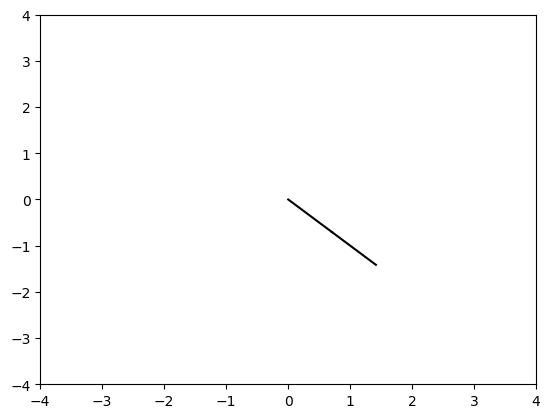

In [10]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes

def plot_pendulum(i,th_in,alph_in,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4])
    
    #plot link 1
    Latopx = X0val
    Latopy = Y0val
    Labottomx = X0val + Laval*np.sin(th_in[i])
    Labottomy = Y0val - Laval*np.cos(th_in[i])
    ax.plot([Latopx,Labottomx],[Latopy,Labottomy],color='xkcd:black')
    
    #plot link 2
    Lpbottomx = Labottomx + Lpval*np.sin(th_in[i] + alph_in[i])
    Lpbottomy = Labottomy - Lpval*np.cos(th_in[i] + alph_in[i]) 
    ax.plot([Labottomx,Lpbottomx],[Labottomy,Lpbottomy],color='xkcd:black')
    
update = lambda i: plot_pendulum(i,thar,alphar,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(N),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

In [11]:
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
import numpy as np

%matplotlib inline

fig1, ax1 = plt.subplots(1, 1)  # create axes

def plot_pendulum(i, th_in, alph_in, ax):  # update function for animation
    ax.clear()
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    
    # Debug: Print current angles
    print(f"Frame {i}: th = {th_in[i]}, alpha = {alph_in[i]}")

    # plot link 1
    Latopy = Y0val
    Latopz = X0val
    Labottomz = X0val + Laval * np.sin(th_in[i])
    Labottomy = Y0val - Laval * np.cos(th_in[i])
    ax.plot([Latopz, Labottomz], [Latopy, Labottomy], color='xkcd:black')
    
    # plot link 2
    Lpbottomz = Labottomz + Lpval * np.sin(th_in[i] + alph_in[i])
    Lpbottomy = Labottomy - Lpval * np.cos(th_in[i] + alph_in[i]) 
    ax.plot([Labottomz, Lpbottomz], [Labottomy, Lpbottomy], color='xkcd:black')

update = lambda i: plot_pendulum(i, thar, alphar, ax1)  # lambdify update function

# Create animation
animate = ani.FuncAnimation(fig1, update, frames=range(N), interval=50, repeat=True)

# Display animation
plt.close(fig1)  # Prevents static display of the last frame
HTML(animate.to_html5_video())  # Convert the animation to HTML5 to embed it in the notebook


Frame 0: th = 0.7853981633974483, alpha = 0
Frame 0: th = 0.7853981633974483, alpha = 0
Frame 1: th = 0.7853981633974483, alpha = 0.0
Frame 2: th = 0.7853981633974483, alpha = 0.0
Frame 3: th = 0.7853981633974483, alpha = 0.0
Frame 4: th = 0.7853981633974483, alpha = 0.0
Frame 5: th = 0.7853981633974483, alpha = 0.0
Frame 6: th = 0.7853981633974483, alpha = 0.0
Frame 7: th = 0.7853981633974483, alpha = 0.0
Frame 8: th = 0.7853981633974483, alpha = 0.0
Frame 9: th = 0.7853981633974483, alpha = 0.0
Frame 10: th = 0.7853981633974483, alpha = 0.0
Frame 11: th = 0.7853981633974483, alpha = 0.0
Frame 12: th = 0.7853981633974483, alpha = 0.0
Frame 13: th = 0.7853981633974483, alpha = 0.0
Frame 14: th = 0.7853981633974483, alpha = 0.0
Frame 15: th = 0.7853981633974483, alpha = 0.0
Frame 16: th = 0.7853981633974483, alpha = 0.0
Frame 17: th = 0.7853981633974483, alpha = 0.0
Frame 18: th = 0.7853981633974483, alpha = 0.0
Frame 19: th = 0.7853981633974483, alpha = 0.0
Frame 20: th = 0.78539816339